## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims
from sklearn.metrics import confusion_matrix, classification_report

## Data Loading

In [17]:
fire = pd.DataFrame(columns=['image', 'width', 'height', 'label'])

for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/train/fire'):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        img = image.load_img(filepath)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255
        fire = fire.append({'image': filepath, 'width': img.size[0], 'height': img.size[1], 'label': 'fire'}, ignore_index=True)

for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/train/non_fire'):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        img = image.load_img(filepath)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255
        fire = fire.append({'image': filepath, 'width': img.size[0], 'height': img.size[1], 'label': 'non_fire'}, ignore_index=True)

for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/test/fire'):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        img = image.load_img(filepath)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255
        fire = fire.append({'image': filepath, 'width': img.size[0], 'height': img.size[1], 'label': 'fire'}, ignore_index=True)

for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/test/non_fire'):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        img = image.load_img(filepath)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255
        fire = fire.append({'image': filepath, 'width': img.size[0], 'height': img.size[1], 'label': 'non_fire'}, ignore_index=True)

In [18]:
fire.head()

,image,width,height,label
0,dataset/fire_dataset/train/fire\fire.152.png,1024,683,fire
1,dataset/fire_dataset/train/fire\fire.153.png,958,641,fire
2,dataset/fire_dataset/train/fire\fire.154.png,500,333,fire
3,dataset/fire_dataset/train/fire\fire.155.png,940,470,fire
4,dataset/fire_dataset/train/fire\fire.156.png,880,495,fire


### Data Characteristics

In [19]:
fire.shape

(1462, 4)

In [23]:
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1462 non-null   object
 1   width   1462 non-null   object
 2   height  1462 non-null   object
 3   label   1462 non-null   object
dtypes: object(4)
memory usage: 45.8+ KB


## Data Cleaning

### Convert Data Types

In [24]:
fire['width'] = fire['width'].astype(int)
fire['height'] = fire['height'].astype(int)

## Exploratory Data Analysis (EDA)

### Label

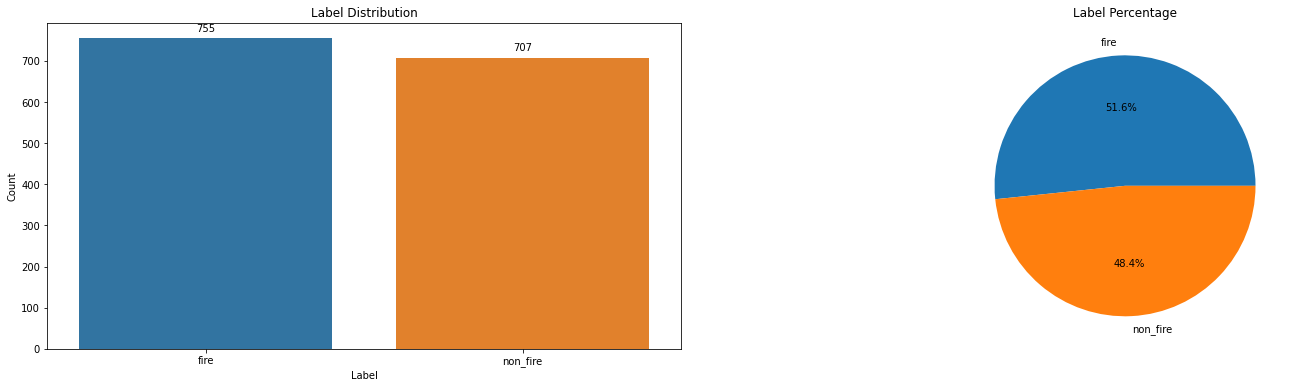

In [28]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
fig = sns.countplot(x='label', data=fire)
for p in fig.patches:
    fig.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.pie(fire.label.value_counts(), labels=fire.label.value_counts().index, autopct='%1.1f%%')
plt.title('Label Percentage')
plt.show()

### Width and Height

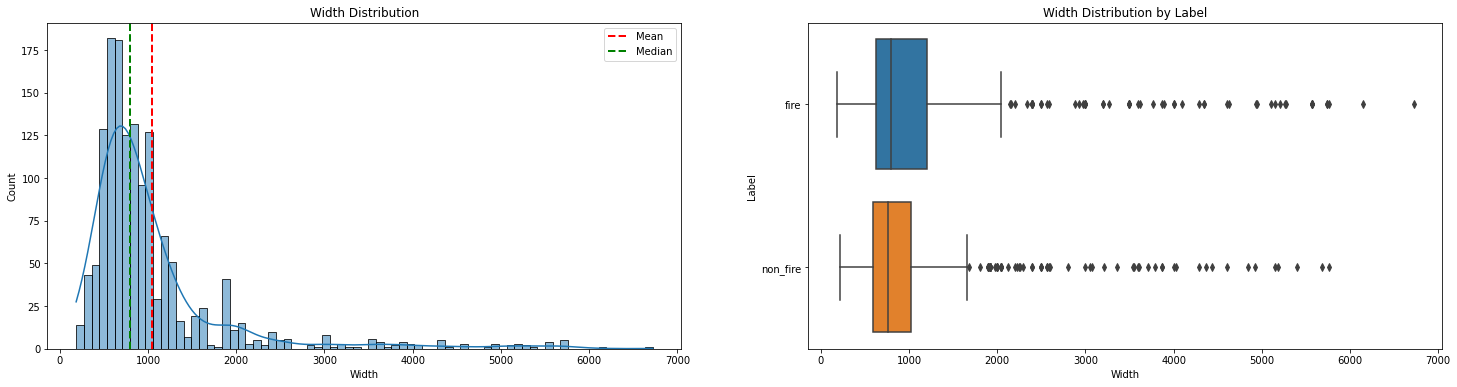

Mean: 1046
Median: 800


In [35]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
sns.histplot(x='width', data=fire, kde=True)
plt.axvline(fire.width.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(fire.width.median(), color='green', linestyle='dashed', linewidth=2, label='Median')
plt.title('Width Distribution')
plt.xlabel('Width')
plt.ylabel('Count')
plt.legend()
plt.subplot(1, 2, 2)
sns.boxplot(x='width', y='label', data=fire)
plt.title('Width Distribution by Label')
plt.xlabel('Width')
plt.ylabel('Label')
plt.show()
print(f'Mean: {fire.width.mean():.0f}')
print(f'Median: {fire.width.median():.0f}')

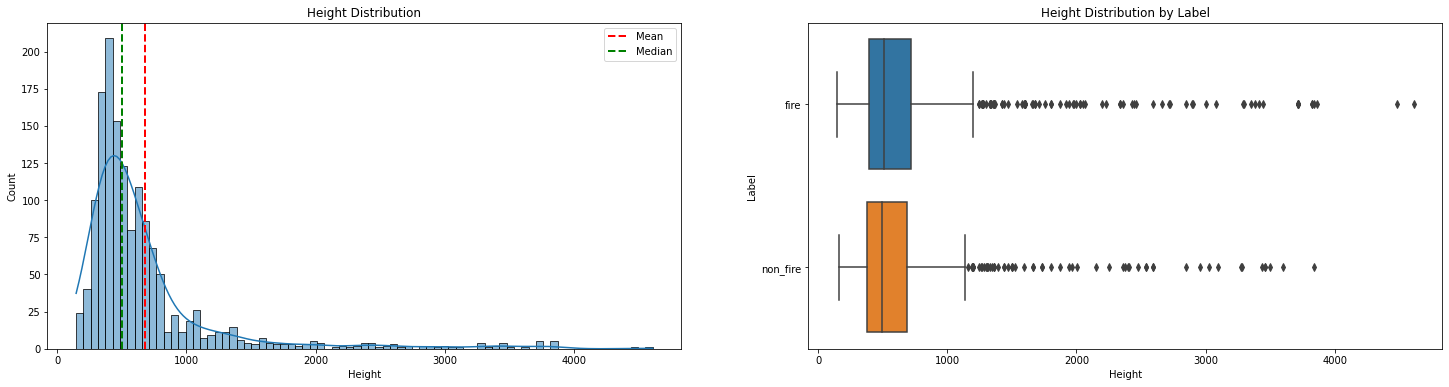

Mean: 678
Median: 500


In [36]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
sns.histplot(x='height', data=fire, kde=True)
plt.axvline(fire.height.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(fire.height.median(), color='green', linestyle='dashed', linewidth=2, label='Median')
plt.title('Height Distribution')
plt.xlabel('Height')
plt.ylabel('Count')
plt.legend()
plt.subplot(1, 2, 2)
sns.boxplot(x='height', y='label', data=fire)
plt.title('Height Distribution by Label')
plt.xlabel('Height')
plt.ylabel('Label')
plt.show()
print(f'Mean: {fire.height.mean():.0f}')
print(f'Median: {fire.height.median():.0f}')

### Sample Images

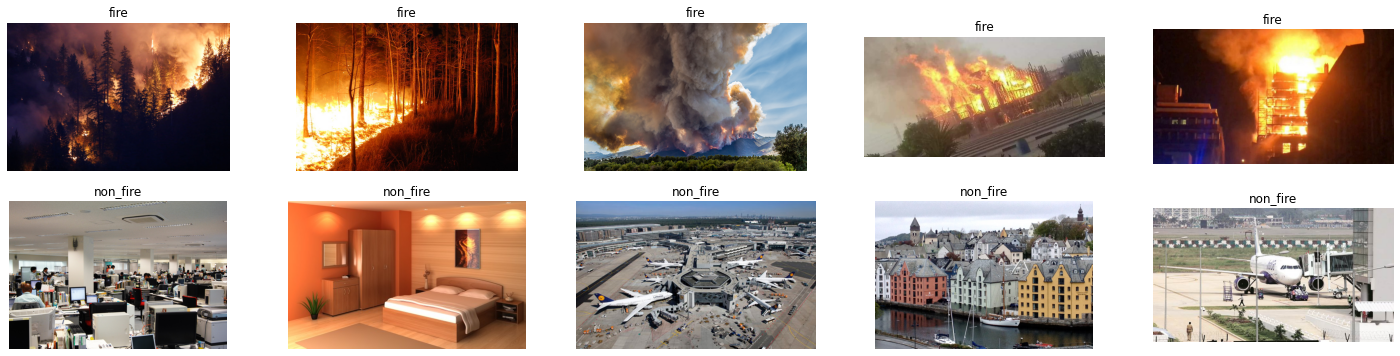

In [43]:
plt.figure(figsize=(25, 6))
counter = 1
for i in ['fire', 'non_fire']:
    for j in range(5):
        plt.subplot(2, 5, counter)
        img = image.load_img(fire[fire.label == i].iloc[j]['image'])
        plt.imshow(img)
        plt.title(i)
        plt.axis('off')
        counter += 1
plt.show()

## Data Preprocessing

In [45]:
train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2)
valid_gen = ImageDataGenerator(rescale=1./255)

train_dir = 'dataset/fire_dataset/train/'
test_dir = 'dataset/fire_dataset/test/'

train_data = train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=23, class_mode='binary')
valid_data = valid_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=23, class_mode='binary')

Found 1170 images belonging to 2 classes.
Found 292 images belonging to 2 classes.


## Model Definition

In [46]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 16)                2

## Model Training

In [48]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, epochs=25, validation_data=valid_data)

Epoch 1/25
51/51 [==============================] - 39s 619ms/step - loss: 0.5532 - accuracy: 0.7573 - val_loss: 0.6108 - val_accuracy: 0.7603
Epoch 2/25
51/51 [==============================] - 30s 587ms/step - loss: 0.3690 - accuracy: 0.8427 - val_loss: 0.7246 - val_accuracy: 0.7226
Epoch 3/25
51/51 [==============================] - 31s 587ms/step - loss: 0.3429 - accuracy: 0.8641 - val_loss: 0.6578 - val_accuracy: 0.7637
Epoch 4/25
51/51 [==============================] - 30s 579ms/step - loss: 0.3195 - accuracy: 0.8701 - val_loss: 0.4185 - val_accuracy: 0.8116
Epoch 5/25
51/51 [==============================] - 30s 597ms/step - loss: 0.3125 - accuracy: 0.8709 - val_loss: 0.5888 - val_accuracy: 0.7911
Epoch 6/25
51/51 [==============================] - 30s 593ms/step - loss: 0.2842 - accuracy: 0.8769 - val_loss: 0.6104 - val_accuracy: 0.7705
Epoch 7/25
51/51 [==============================] - 30s 583ms/step - loss: 0.2887 - accuracy: 0.8718 - val_loss: 0.5986 - val_accuracy: 0.7808

## Model Evaluation

In [49]:
metrics = pd.DataFrame(history.history)
metrics.tail()

,loss,accuracy,val_loss,val_accuracy
20,0.215563,0.909402,0.325095,0.856164
21,0.238725,0.917949,0.383607,0.811644
22,0.221139,0.916239,0.672765,0.787671
23,0.234920,0.913675,0.368785,0.859589
24,0.211022,0.916239,0.277253,0.876712


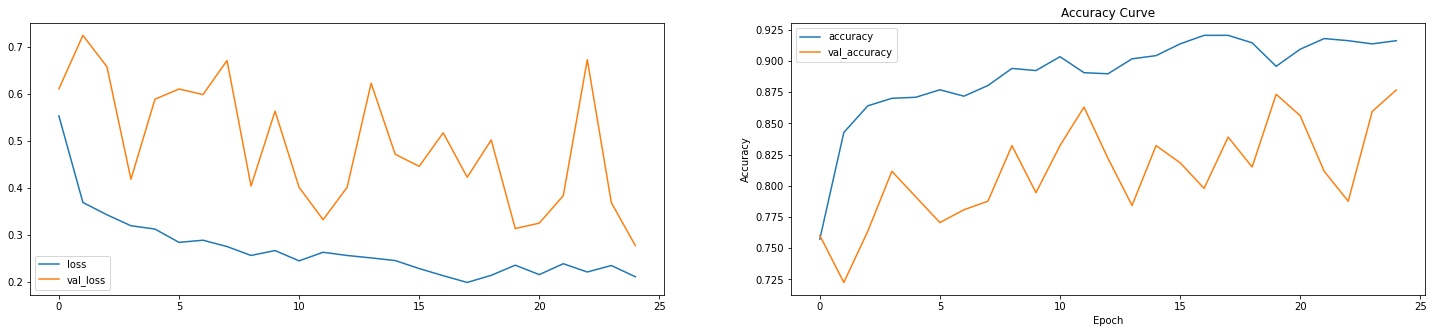

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(25, 5))
metrics[['loss', 'val_loss']].plot(ax=ax[0])
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1])
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()